In [70]:
%matplotlib inline 

import os
import re
import csv

import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_context('poster')
sns.set_style('whitegrid')

In [18]:
def parse_server_log(path, host=None):
    clipat = re.compile(r'^(\d+) remote clients - (\d+) (\w+) (\d+) (\w+)$')
    conpat = re.compile(r'^\[honu\] ([\d\.:]+) created (\w+) consistency storage$')
    thrpat = re.compile(r'^\[honu\] ([\d\.:]+) (\d+) accesses \(\d+ reads, \d+ writes\) in ([\d\.]+)s -- ([\d\.]+) accesses/second$')

    clients = None 
    servers = {}
    consistency = None 
    
    with open(path, 'r') as f:
        for line in f:
            line = line.strip() 
            
            match = clipat.match(line)
            if match is not None:
                parts = match.groups()
                clients = parts[0]
                servers[parts[2]] = int(parts[1])
                servers[parts[4]] = int(parts[3])
            
            match = conpat.match(line)
            if match is not None:
                consistency = match.groups()[1]
            
            match = thrpat.match(line)
            if match is not None:
                row = {
                    "host": host, 
                    "role": "server",
                    "clients": clients, 
                    "consistency": consistency, 
                    "accesses": int(match.groups()[1]),
                    "seconds": float(match.groups()[2]),
                    "throughput (accesses/sec)": float(match.groups()[3]),
                }
                row.update(servers)
                yield row

In [20]:
with open('server-throughput.csv', 'w') as out:
    writer = csv.DictWriter(out, fieldnames=("host", "role", "clients", "consistency", "accesses", "seconds", "throughput (accesses/sec)", "hyperion", "lagoon"))
    writer.writeheader()
    
    for row in parse_server_log('throughput-server-nevis.txt', 'nevis'):
        writer.writerow(row)

In [22]:
def parse_client_log(path, host=None):
    clipat = re.compile(r'^(\d+) local (\d+) remote clients$')
    thrpat = re.compile(r'^(\d+) messages sent in ([\d\.]+)s \(([\d\.]+) msg\/sec(, ([\d\.]+) ns\/msg)?\)$')

    clients = None 
    local = None 
    remote = None 
    
    with open(path, 'r') as f:
        for line in f:
            line = line.strip() 
            
            match = clipat.match(line)
            if match is not None:
                local = int(match.group(1))
                remote = int(match.group(2))
                clients = local + remote
            
            match = thrpat.match(line)
            if match is not None:
                row = {
                    "host": host,
                    "role": "client",
                    "clients": clients, 
                    "local": local, 
                    "remote": remote, 
                    "accesses": int(match.groups()[0]),
                    "seconds": float(match.groups()[1]),
                    "throughput (accesses/sec)": float(match.groups()[2]),
                }
                yield row

In [23]:
with open('clients-throughput.csv', 'w') as out:
    writer = csv.DictWriter(out, fieldnames=("host", "role", "clients", "accesses", "seconds", "throughput (accesses/sec)", "local", "remote"))
    writer.writeheader()
    
    for name in ('hyperion', 'lagoon'):
        path = "throughput-client-{}.txt".format(name)
        for row in parse_client_log(path, name):
            writer.writerow(row)

In [25]:
server = pd.read_csv('server-throughput.csv')
clients = pd.read_csv('clients-throughput.csv')

In [26]:
server.dtypes

host                          object
role                          object
clients                        int64
consistency                   object
accesses                       int64
seconds                      float64
throughput (accesses/sec)    float64
hyperion                       int64
lagoon                         int64
dtype: object

In [27]:
clients.dtypes

host                          object
role                          object
clients                        int64
accesses                       int64
seconds                      float64
throughput (accesses/sec)    float64
local                          int64
remote                         int64
dtype: object

In [28]:
server.describe()

,clients,accesses,seconds,throughput (accesses/sec),hyperion,lagoon
count,120.000000,1.200000e+02,120.000000,120.000000,120.000000,120.000000
mean,15.000000,5.514404e+05,30.016718,18365.771701,7.500000,7.500000
std,11.423844,3.670451e+05,0.016605,12219.061532,5.717436,5.717436
min,1.000000,3.010600e+04,29.998120,1003.565100,0.000000,0.000000
25%,4.750000,2.000578e+05,30.005115,6667.820725,2.000000,2.000000
50%,13.000000,5.597635e+05,30.012753,18651.152650,6.500000,6.500000
75%,24.500000,8.993130e+05,30.023624,29951.313625,12.250000,12.250000
max,36.000000,1.085637e+06,30.087031,36118.791600,18.000000,18.000000


In [29]:
clients.describe()

,clients,accesses,seconds,throughput (accesses/sec),local,remote
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,23.627778,36762.710556,29.664182,1238.689647,11.822222,11.805556
std,9.614024,8937.696794,0.099388,298.538243,4.790387,4.826158
min,1.000000,25456.000000,29.464322,858.876700,1.000000,0.000000
25%,17.500000,29508.500000,29.569199,997.850750,8.750000,8.750000
50%,26.000000,34179.500000,29.649299,1149.756650,13.000000,13.000000
75%,32.000000,42726.500000,29.752683,1435.859800,16.000000,16.000000
max,36.000000,55945.000000,29.808403,1880.821400,18.000000,18.000000


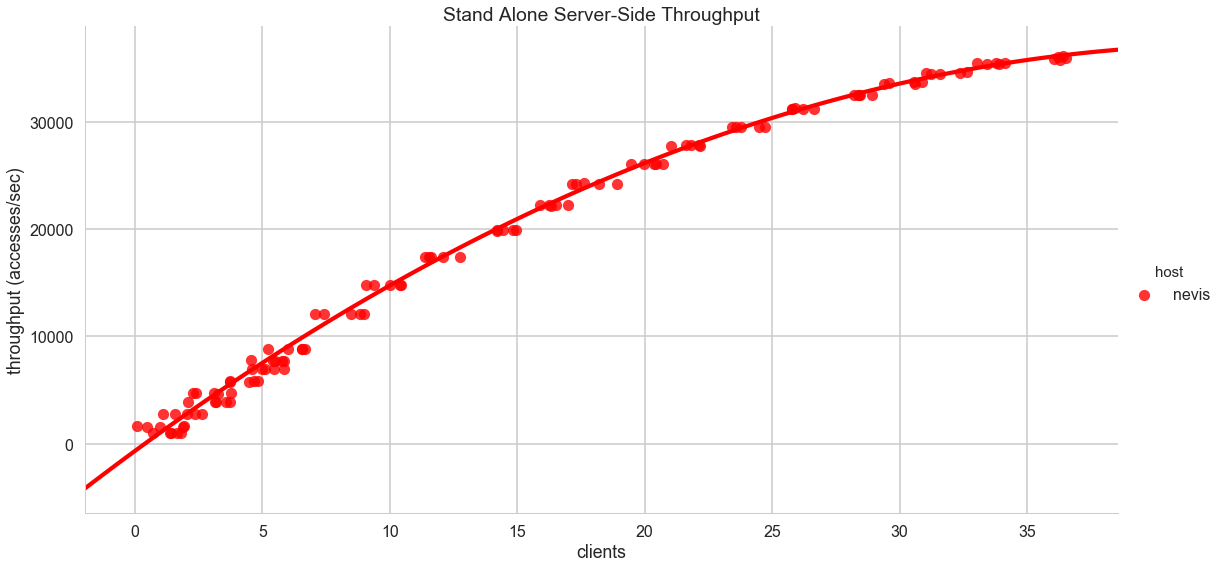

In [103]:
g = sns.lmplot(x="clients", y="throughput (accesses/sec)", data=server, x_jitter=1, order=2, size=8, aspect=2, hue="host", line_kws={'color': 'r'}, scatter_kws={'color': 'r'})
plt.title("Stand Alone Server-Side Throughput")

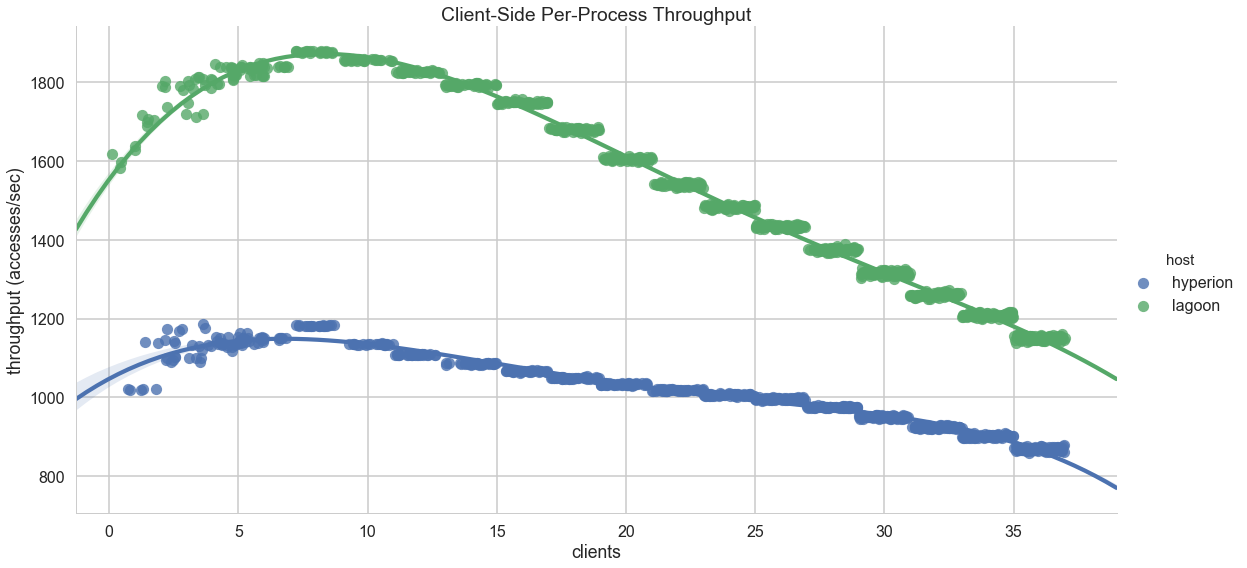

In [104]:
# df = pd.DataFrame(clients.groupby(['clients', 'host']).mean().to_records())
g = sns.lmplot(x="clients", y="throughput (accesses/sec)", x_jitter=1, hue='host', data=clients, order=4, size=8, aspect=2)
plt.title("Client-Side Per-Process Throughput")